In [57]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
import warnings
import spacy
import torch.nn as nn
from anchor import anchor_text
import pickle
from myUtils import *
from transformer.utils import *
from dataset.dataset_loader import *
import transformer.training as training
import transformer.plot as plot
import pandas as pd

SEED = 84
torch.manual_seed(SEED)
warnings.simplefilter("ignore")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [58]:
plt.rcParams['font.size'] = 20
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [91]:
review_parser, label_parser, ds_train, ds_valid, ds_test = create_sentiment_dataset()

Number of tokens in training samples: 3307
Number of tokens in training labels: 2


In [60]:
anchor_examples = pickle.load( open( "results/transformer_anchor_examples.pickle", "rb" ))
explanations = pickle.load(open( "results/gru_extended_counter_exps.pickle", "rb" ))
#explanations = [exp for exp in explanations if len(exp.fit_examples)] 
predictions = pickle.load(open( "results/gru_train_predictions.pickle", "rb" ))

In [41]:
predictions[:10]

[tensor(-0.9670, device='cuda:0', requires_grad=True),
 tensor(-0.8306, device='cuda:0', requires_grad=True),
 tensor(0.7846, device='cuda:0', requires_grad=True),
 tensor(0.5805, device='cuda:0', requires_grad=True),
 tensor(-0.8827, device='cuda:0', requires_grad=True),
 tensor(-0.7858, device='cuda:0', requires_grad=True),
 tensor(0.7640, device='cuda:0', requires_grad=True),
 tensor(-0.6994, device='cuda:0', requires_grad=True),
 tensor(-0.8751, device='cuda:0', requires_grad=True),
 tensor(-0.9215, device='cuda:0', requires_grad=True)]

In [16]:
len(predictions)

7000

In [61]:
from collections import Counter, defaultdict
from nltk.corpus import stopwords
from sklearn.preprocessing import MinMaxScaler
def get_occurences(ds):
    c = Counter()
    ignore = list(".,- \'\"\s[]?():!;")
    ignore.extend(["--", "'s"])
    ignore.extend(stopwords.words('english'))
    for ds_example in ds:
        c.update(ds_example.text)
    for ignore_s in ignore:
        del c[ignore_s]
    values = np.array(list(c.values())).reshape(-1,1)
    scaler = MinMaxScaler().fit(values)
    for word in c.keys():
        c[word] = scaler.transform([[c[word]]])[0][0] + 1e-5
    return c

In [62]:
def get_label_distribution(ds):
    c_pos = Counter()
    c_neg = Counter()
    c = Counter()
    ignore = list(".,- \'\"\s[]?():!;")
    ignore.extend(["--", "'s"])
    ignore.extend(stopwords.words('english'))
    
    for ds_example in ds:
        if ds_example.label == 'positive':
            c_pos.update(set(ds_example.text))
        else:
            c_neg.update(set(ds_example.text))

    all_words = list(c_pos.keys())
    all_words.extend(c_neg.keys())
    all_words = set(all_words)
    for word in all_words:
        c[word] = (c_pos[word]-c_neg[word])/(c_pos[word]+c_neg[word])
    for ignore_s in ignore:
        c[ignore_s]=0
    
    return c

In [63]:
def get_prediction_distribution(ds, predictions):
    d = defaultdict(list)
    ignore = list(".,- \'\"\s[]?():!;")
    ignore.extend(["--", "'s"])
    ignore.extend(stopwords.words('english'))
    
    for ds_example, prediction in zip(ds, predictions):
        for word in ds_example.text:
            d[word].append(prediction)

    prediction_dict = defaultdict(lambda: 0.0)
    
    for word, values in d.items():
        prediction_dict[word] = sum(values)/len(values)
    for ignore_s in ignore:
        prediction_dict[ignore_s]=0.0
    
    return prediction_dict

In [92]:
label_distribution = get_label_distribution(ds_train)
occurences = get_occurences(ds_train)
prediction_dist = get_prediction_distribution(ds_train, predictions)
statistics = [label_distribution, occurences, prediction_dist]

In [65]:
import copy
def generate_example(ds, anchor_examples, explanations):
    filtered_examples = []
    for example in ds:
        for exp in explanations:     
            if ' '.join(example.text)==anchor_examples[exp.index]:
                c_example = copy.deepcopy(example)
                if exp.test_precision < 0.5:
                    c_example.label = 'negative'
                else:
                     c_example.label = 'positive'
                filtered_examples.append(c_example)
                
                break
                
    return filtered_examples

In [96]:
import copy
def generate_example(ds, anchor_examples, explanations):
    filtered_examples = []
    for example in ds:
        for exp in explanations:     
            if ' '.join(example.text)==anchor_examples[exp.index]:
                c_example = copy.deepcopy(example)
                if exp.test_precision < 0.5:
                    c_example.label = 0
                else:
                     c_example.label = 1
             
                filtered_examples.append(c_example)
                
                break
                
    return filtered_examples

In [97]:
examples = generate_example(ds_train, anchor_examples, explanations)

In [98]:
size = len(examples)
train_size = round(0.75*size)
ds_train.examples = examples[:train_size]
ds_valid.examples = examples[train_size:]
ds_test = ds_valid

# Bert

In [16]:
def save_to_csv(examples, name):
    text = [' '.join(example.text) for example in examples]
    label = [example.label for example in examples]
    pd.DataFrame({'review': text, 'label': label}).to_csv(f'dataset/hugging/{name}.csv')

In [17]:
save_to_csv(train_examples, 'train')
save_to_csv(valid_examples, 'dev')

In [ ]:
from transformer.huggingUtils import *
set_seed()
model = load_model('roberta-base')
data = load_data('dataset/hugging', 'dataset/hugging')
tokenized_data = tokenize_dataset(data, tokenizer_name='roberta-base')
train(model, tokenized_data)

# GRU

In [80]:
import tqdm
import sys
def forward_dl(model, dl, device, type_dl):
    model.train(False)
    num_samples = len(dl) * dl.batch_size
    num_batches = len(dl)  
    pbar_name = type(model).__name__
    list_y_real = []
    list_y_pred = []
    pbar_file = sys.stdout
    num_correct = 0
    dl_iter = iter(dl)
    for batch_idx in range(num_batches):
        data = next(dl_iter)
        x, y = data.text, data.label
        list_y_real.append(y)
        x = x.to(device)  # (S, B, E)
        y = y.to(device)  # (B,)
        with torch.no_grad():
            if isinstance(model, models.VanillaGRU):
                y_pred_log_proba = model(x)
            elif isinstance(model, models.MultiHeadAttentionNet):
                y_pred_log_proba, _ = model(x)
            y_pred = torch.argmax(y_pred_log_proba, dim=1)
            num_correct += torch.sum(y_pred == y).float().item()
            list_y_pred.append(y_pred)
    accuracy = 100.0 * num_correct / num_samples
    print(f'Accuracy for {type_dl} is {accuracy}')
    
    all_y_real = torch.cat(list_y_real)
    all_y_pred = torch.cat(list_y_pred)
    return all_y_real, all_y_pred, accuracy

In [14]:
def get_classes_for_csv():
    classes = None
    if type_dataset == 'trinary':
        classes = ['positive', 'negative', 'neutral']
    elif type_dataset == 'binary':
        classes = ['positive', 'negative']
    elif type_dataset == 'fine_grained':
        classes = ['positive', 'negative', 'neutral', 'very_positive', 'very_negative']
    index_csv = [f'pred_{curr_class}' for curr_class in classes]
    columns_csv = [f'real_{curr_class}' for curr_class in classes]
    return classes, index_csv, columns_csv

In [55]:
import pandas as pd

def compute_confusion_matrix(y_real, y_pred, model_name, type_dl):
    classes, index_csv, columns_csv = get_classes_for_csv()
    num_classes = len(classes)
    num_classes_in_y = len(torch.unique(y_real))
    assert num_classes == num_classes_in_y, 'Mismatch in number of classes'
    confusion_matrix = torch.zeros(num_classes, num_classes)
    for class_index, class_name in enumerate(classes):
            all_pred_classes = y_pred[y_real == class_index]
            curr_col = torch.histc(all_pred_classes, bins=num_classes, min=0, max=num_classes - 1)
            confusion_matrix[:, class_index] = curr_col
    confusion_matrix = confusion_matrix.numpy()
    df = pd.DataFrame(confusion_matrix, index = index_csv, columns = columns_csv, dtype=int)
    #df.to_csv(output_directory / str('confusion_matrix_' + model_name + '_' + type_dl + '.csv'))
    return df

In [75]:
import torch.optim as optim
import numpy as np
import pandas as pd
from pathlib import Path
def train_model(model_name, device, output_directory = 'results', task = 'classification'):
    NUM_EPOCHS = 100
    loss_fn = nn.NLLLoss()
    hp = load_hyperparams(model_name, type_dataset)
    if task == 'regression':
        hp['output_classes'] = 1
        loss_fn = nn.MSELoss()
        
    if model_name == 'gru':
        model = models.VanillaGRU(review_parser.vocab, hp['embedding_dim'], hp['hidden_dim'], hp['num_layers'], hp['output_classes'], hp['dropout'], statistics).to(device)
    elif model_name == 'attention':
        model = models.MultiHeadAttentionNet(input_vocabulary=review_parser.vocab, embed_dim=hp['embedding_dim'], num_heads=hp['num_heads'], 
                                           dropout=hp['dropout'], two_attention_layers=hp['two_atten_layers'], output_classes=hp['output_classes']).to(device)
    print(model)

    dl_train, dl_valid, dl_test = torchtext.legacy.data.BucketIterator.splits((ds_train, ds_valid, ds_test), batch_size=hp['batch_size'], sort = False, shuffle=False, device=device)
 
    optimizer = optim.Adam(model.parameters(), lr=hp['lr'])
    
    trainer = training.SentimentTrainer(model, loss_fn, optimizer, device)
    checkpoint_filename = str(output_directory) +  '/' + model_name
    print(f'Saving checkpoint with prefix: {checkpoint_filename}')
    fit_res = trainer.fit(dl_train, dl_valid, NUM_EPOCHS, early_stopping = hp['early_stopping'], checkpoints = checkpoint_filename, params = hp)

    fig, axes = plot.plot_fit(fit_res)
    fig.savefig(output_directory + '/' + str(model_name + '.png'))
    saved_state = torch.load(checkpoint_filename + '.pt', map_location=device)
    model.load_state_dict(saved_state["model_state"])
    loaded_hp = saved_state["parameters"]
    print('----- Loaded params ------')
    print(loaded_hp)
    if task == 'classification':
        all_dataloaders = [dl_train, dl_valid, dl_test]
        type_dls = ['train', 'valid', 'test']
        accuracies = []
        for dl, type_dl in zip(all_dataloaders, type_dls):
            y_real, y_pred, accuracy = forward_dl(model, dl, device, type_dl)
            df = compute_confusion_matrix(y_real, y_pred, model_name, type_dl)
            accuracies.append(accuracy)
            display(df)
        numpy_accuracy = np.array(accuracies)
        df = pd.DataFrame(numpy_accuracy, index = type_dls, dtype=float)
        df.to_csv(output_directory + '/' + str('accuracies_' + model_name + '.csv')) 

{'embedding_dim': 100, 'batch_size': 32, 'hidden_dim': 256, 'num_layers': 2, 'dropout': 0.3, 'lr': 0.0005, 'early_stopping': 8, 'output_classes': 2}
VanillaGRU(
  (embedding_layer): Embedding(3307, 103)
  (GRU_layer): GRU(103, 256, num_layers=2, dropout=0.3)
  (dropout_layer): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=256, out_features=2, bias=True)
  (log_softmax): LogSoftmax(dim=1)
)
Saving checkpoint with prefix: results/gru
--- EPOCH 1/100 ---
train_batch (Avg. Loss 0.546, Accuracy 75.0): 100%|█| 19/19 [00:00<00:00, 131.75
test_batch (Avg. Loss 0.553, Accuracy 66.1): 100%|█| 7/7 [00:00<00:00, 324.51it/
*** Saved checkpoint results/gru.pt at epoch 1
--- EPOCH 2/100 ---
train_batch (Avg. Loss 0.504, Accuracy 79.3): 100%|█| 19/19 [00:00<00:00, 149.66
test_batch (Avg. Loss 0.575, Accuracy 66.1): 100%|█| 7/7 [00:00<00:00, 410.71it/
--- EPOCH 3/100 ---
train_batch (Avg. Loss 0.490, Accuracy 79.3): 100%|█| 19/19 [00:00<00:00, 151.84
test_batch (Avg. Loss 0.558, Accuracy 66.

,real_positive,real_negative
pred_positive,39,17
pred_negative,81,465


Accuracy for valid is 70.08928571428571


,real_positive,real_negative
pred_positive,15,6
pred_negative,38,142


Accuracy for test is 70.08928571428571


,real_positive,real_negative
pred_positive,15,6
pred_negative,38,142


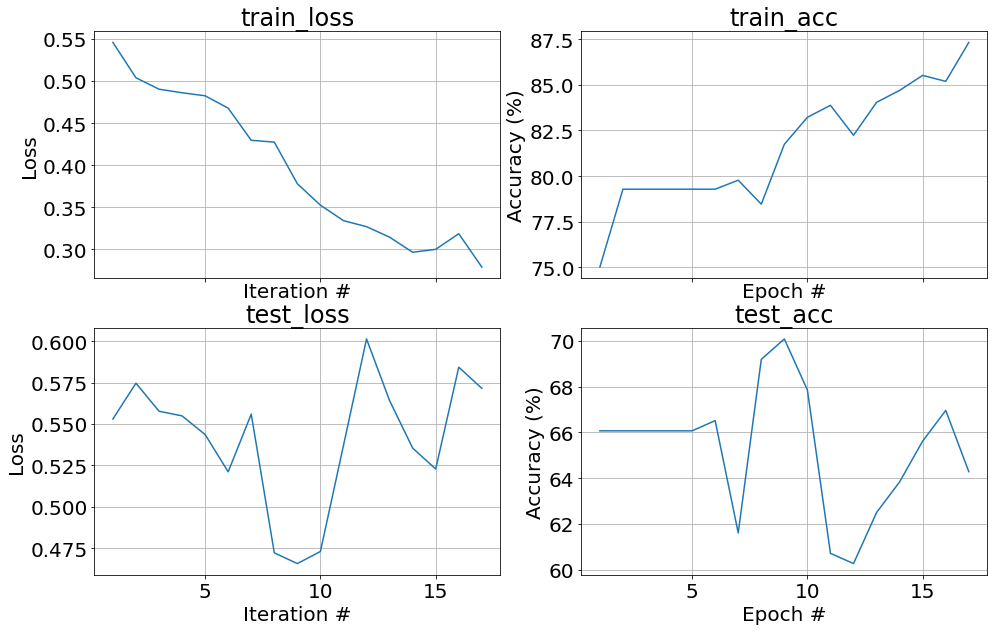

In [101]:
import os
if os.path.isfile("results/gru.pt"):
    os.remove("results/gru.pt")
SEED = 84
torch.manual_seed(SEED)
train_model('gru', device,)

In [ ]:
git stat